# The Hadamard Test

In [1]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

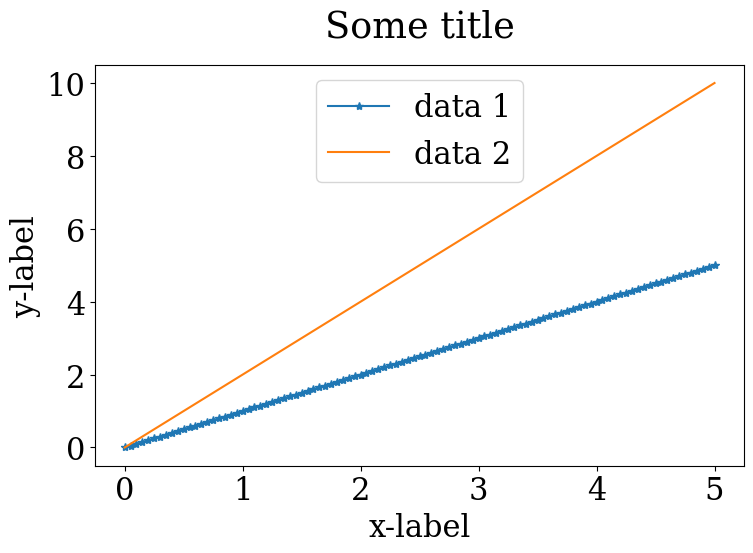

In [2]:
import numpy as np
import matplotlib.pyplot as plt


if __name__ == "__main__":

    plt.rcParams["font.family"] = "serif"
    plt.rcParams["mathtext.fontset"] = "dejavuserif"

    # NOTE I usually make plots 0.5*\textwidth; this font size is legible 
    plt.rcParams.update({"font.size": 22})

    resolution = 150

    x_data = np.linspace(0, 5, num=101)
    y_data1 = x_data
    y_data2 = 2 * x_data

    fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

    ax1.plot(x_data, y_data1, "-*", label="data 1")
    ax1.plot(x_data, y_data2, "-", label="data 2")

    # ax1.set_yscale('log')
    # ax1.set_xscale('log')
    # ax1.set_ylim([0.,2])

    ax1.legend(loc="upper center")
    ax1.set_title("Some title", pad=20)
    ax1.set_xlabel("x-label")
    ax1.set_ylabel("y-label")

    fig.tight_layout()
    fig.savefig(
        "",
        bbox_inches="tight",
        dpi=resolution,
        transparent=True,
        facecolor="w",
        edgecolor="w",
        orientation="landscape",
    )

    plt.show()

## Hadamard Test

The simplest way to estimate $\varphi$ with a quantum computer is to use the Hadamard test. This test is a very useful tool for estimating the expectation value of a unitary operator with respect to some state, i.e., $\langle \psi|U|\psi\rangle$. Our unitary operator $U$ is not generally a Hermitian matrix meaning its eigenvalues can be complex. Therefore this does not correspond to the measurement of a physical observable, which means we need to encode it into something physical we can measure. For this method, we measure the real and imaginary part of the expectation value seperately.

Lets start by looking at the the real and imaginary Hadamard Test Circuits.

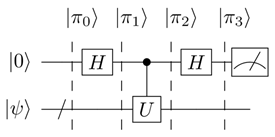

$$\text{Fig. }5:\text{ Hadamard test for Re}\langle\psi |U|\psi\rangle$$

The unitary operator $U$ will apply the phase of $|\psi\rangle$ onto $q_0$.

### Proof

Looking at the real Hadamard test in $\text{Fig. }3$, the intial state of our circuit can be represented as

$$|\pi_0\rangle = |0\rangle \otimes |\psi\rangle = |0\rangle|\psi\rangle = \begin{pmatrix}1 \\ 0\end{pmatrix}|\psi\rangle$$

We then apply the Hadamard gate to the control qubit transforming it to the $|+\rangle$ state

$$|\pi_1\rangle 
= (H \otimes I) \cdot (|0\rangle|\psi\rangle)
= H|0\rangle I|\psi\rangle
= \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}\begin{pmatrix}1\\0\end{pmatrix}|\psi\rangle
= \frac{1}{\sqrt{2}}\begin{pmatrix} (1\cdot 1) + (1\cdot 0) \\(1\cdot 1) + (-1\cdot 0) \end{pmatrix}|\psi\rangle 
= \frac{1}{\sqrt{2}}\begin{pmatrix} 1\\1 \end{pmatrix}|\psi\rangle
= \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle \right)|\psi\rangle 
= |+\rangle|\psi\rangle$$

Next the controlled-unitary operator is performed resulting in the following state rotating $q_0$ equivent to the eigenvalue of $|\psi\rangle$

$$|\pi_2\rangle 
= CU|+\rangle|\psi\rangle
= \frac{1}{\sqrt{2}}|0\rangle|\psi\rangle + \frac{1}{\sqrt{2}} |1\rangle U|\psi\rangle 
= \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 0\\0 & e^{i\theta}\end{pmatrix}\begin{pmatrix} 1\\1 \end{pmatrix}|\psi\rangle 
= \frac{1}{\sqrt{2}} \begin{pmatrix} (1\cdot 1) + (0\cdot 1) \\ (0\cdot 1) + (1\cdot e^{i\theta})\end{pmatrix}|\psi\rangle 
= \frac{1}{\sqrt{2}} \begin{pmatrix} 1\\ e^{i\theta}\end{pmatrix}|\psi\rangle 
= \frac{1}{\sqrt{2}}\left(|0\rangle + e^{i\theta}|1\rangle \right)|\psi\rangle$$

Finally, we apply the second Hadamard gate to the circuit leaving us with the state

$$|\pi_3\rangle = H\frac{1}{\sqrt{2}}\left(|0\rangle + e^{i\theta}|1\rangle \right)|\psi\rangle = \frac{1}{2}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}\begin{pmatrix} 1\\ e^{i\theta}\end{pmatrix}|\psi\rangle = \frac{1}{2}\begin{pmatrix} (1\cdot 1) + (1\cdot e^{i\theta}) \\(1\cdot 1) + (-1\cdot e^{i\theta})\end{pmatrix}|\psi\rangle = \frac{1}{2}\begin{pmatrix} 1 + e^{i\theta} \\1 - e^{i\theta}\end{pmatrix}|\psi\rangle = \left(\frac{1+e^{i\theta}}{2}|0\rangle + \frac{1-e^{i\theta}}{2}|1\rangle\right)|\psi\rangle$$

For simplicity in calculating the probabilities, this can also be represented as matrix operations on $|\psi\rangle$
$$|0\rangle\frac{I+U}{2}|\psi\rangle + |1\rangle\frac{I-U}{2}|\psi\rangle$$

Since we know the probability of a quantum state comes from the probability amplitude times its complex conjugate, we can calculate the final probablities. We will first look at the probability of measuring the qubit $0$ to be in the $|0\rangle$ state.

$$\mathbb{P}_{\text{Re}}(|0\rangle) 
= |\langle 0|\pi_3\rangle|^2 
=\left| \langle 0|0\rangle\frac{I+U}{2}|\psi\rangle + \langle0|1\rangle\frac{I-U}{2}|\psi\rangle\right|^2 
= \left|\frac{I+U}{2}|\psi\rangle\right|^2 
= \frac{\langle \psi|(I+U^{\dagger})(I+U)|\psi\rangle}{4} 
= \frac{\langle \psi|(I+U+U^{\dagger}+U^{\dagger}U)|\psi\rangle}{4}$$

If we now take a similar process for the probability of measuring qubit $0$ to be in the $|1\rangle$ state, we get the following

$$\mathbb{P}_{\text{Re}}(|1\rangle) 
= |\langle 1|\pi_3\rangle|^2 
= \left| \langle 1|0\rangle\frac{I+U}{2}|\psi\rangle + \langle 1|1\rangle\frac{I-U}{2}|\psi\rangle\right|^2 
= \left|\frac{I-U}{2}|\psi\rangle\right|^2 
= \frac{\langle \psi|(I-U^{\dagger})(I-U)|\psi\rangle}{4} 
= \frac{\langle \psi|(I-U-U^{\dagger}+U^{\dagger}U)|\psi\rangle}{4}$$

Using the fact that $U^\dagger U = I$, these probabilites can be simplified further

$$\mathbb{P}_{\text{Re}}(|0\rangle) =  \frac{\langle \psi|(I+U+U^{\dagger}+U^{\dagger}U)|\psi\rangle}{4} = \frac{\langle \psi|(2I+U+U^{\dagger})|\psi\rangle}{4} = \frac{2 + \langle \psi|(U+U^{\dagger})|\psi\rangle}{4}$$

$$\mathbb{P}_{\text{Re}}(|1\rangle) =  \frac{\langle \psi|(I-U-U^{\dagger}+U^{\dagger}U)|\psi\rangle}{4} = \frac{\langle \psi|(2I-U-U^{\dagger})|\psi\rangle}{4} = \frac{2 - \langle \psi|(U+U^{\dagger})|\psi\rangle}{4}$$

For a unitary operator $U$, $\langle\alpha|U|\beta\rangle = (\langle\alpha|U|\beta\rangle)^\dagger = \langle\beta|U^{\dagger}|\alpha\rangle$, therefore if $\alpha = \beta$ such as in our case, $\langle\psi|U|\psi\rangle = \langle\psi|U^{\dagger}|\psi\rangle$. Applying this to our probablity equations, we get the following:

$$\mathbb{P}_{\text{Re}}(|0\rangle) = \frac{2 + \langle \psi|(U+U^{\dagger})|\psi\rangle}{4} = \frac{2 + 2\text{Re}\langle\psi|U|\psi\rangle}{4} = \frac{1}{2}(1+\text{Re}\langle\psi|U|\psi\rangle)$$

$$\mathbb{P}_{\text{Re}}(|1\rangle) = \frac{2 - \langle \psi|(U+U^{\dagger})|\psi\rangle}{4} = \frac{2 - 2\text{Re}\langle\psi|U|\psi\rangle}{4} = \frac{1}{2}(1-\text{Re}\langle\psi|U|\psi\rangle)$$

Now that we have the probability of measuring $|0\rangle$ on $q_0$ and the probability of measuring $|1\rangle$ on $q_0$, we can now calculate the real component of the phase.

$$\mathbb{P}_{\text{Re}}(|0\rangle) - \mathbb{P}_{\text{Re}}(|1\rangle) 
= \frac{1}{2}(1+\text{Re}\langle\psi|U|\psi\rangle) - \frac{1}{2}(1-\text{Re}\langle\psi|U|\psi\rangle)
= \frac{1}{2}\text{Re}\langle\psi|U|\psi\rangle + \frac{1}{2}\text{Re}\langle\psi|U|\psi\rangle
=  \text{Re}\langle\psi|U|\psi\rangle$$

$$2\mathbb{P}_{\text{Re}}(|0\rangle) - 1
= 2 \left(\frac{1}{2}(1+\text{Re}\langle\psi|U|\psi\rangle)\right) - 1
=  (1+\text{Re}\langle\psi|U|\psi\rangle)  - 1
=  \text{Re}\langle\psi|U|\psi\rangle$$

$$1 - 2\mathbb{P}_{\text{Re}}(|1\rangle)
=  1  2 \left(\frac{1}{2}(1-\text{Re}\langle\psi|U|\psi\rangle)\right)
=  1-(\text{Re}\langle\psi|U|\psi\rangle - 1)
=  \text{Re}\langle\psi|U|\psi\rangle$$

Therefore, the real expectation value can be found from these probabilities in the following three different ways:

\begin{equation}
\begin{aligned}
\mathbb{P}_{\text{Re}}(|0\rangle) - \mathbb{P}_{\text{Re}}(|1\rangle) = 2\mathbb{P}_{\text{Re}}(|0\rangle) - 1 = 1 - 2\mathbb{P}_{\text{Re}}(|1\rangle) =\text{Re}\langle\psi|U|\psi\rangle 
\end{aligned}
\tag{1}
\label{re_prob}
\end{equation}

The approach to obtain the imaginary part of the expectation value is almost exactly the same as the real part. This time, though, we will use the imaginary Hadamard test circuit which contains the addition of a phase gate $S = \begin{pmatrix} 1 & 0\\0 & i\end{pmatrix}$ on the control qubit as shown in $\text{Fig. }6$. 

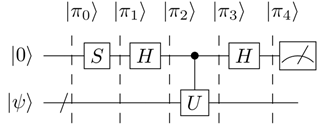

$$\text{Fig. }6:\text{ Hadamard test for Im}\langle\psi |U|\psi\rangle$$

The first two states $|\pi_0\rangle$ and $|\pi_1\rangle$ are the same as for the real test.

$$|\pi_0\rangle = |0\rangle|\psi\rangle = \begin{pmatrix}1\\0\end{pmatrix}|\psi\rangle$$

$$|\pi_1\rangle = H|0\rangle|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}\begin{pmatrix}1\\0\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1\\1 \end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle \right)|\psi\rangle = |+\rangle|\psi\rangle$$

Now the phase gate $S$ is applied to this state giving us the following

$$|\pi_2\rangle = S|+\rangle|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 0\\0 & i\end{pmatrix}\begin{pmatrix} 1\\1\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} (1\cdot 1) +  (0\cdot 1)\\(0\cdot 1) + (i\cdot 1)\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1\\i\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + i|1\rangle \right)|\psi\rangle$$

Performing the controlled-$U$ we get

$$|\pi_3\rangle = \frac{1}{\sqrt{2}}|0\rangle|\psi\rangle + \frac{1}{\sqrt{2}}i|1\rangle U|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 0\\0 & e^{i\theta}\end{pmatrix}\begin{pmatrix} 1\\i\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} (1\cdot 1) + (0\cdot i) \\(0\cdot 1) + (e^{i\theta}\cdot i)\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1\\ie^{i\theta}\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}(|0\rangle + ie^{i\theta}|1\rangle)|\psi\rangle$$

Lastly, we apply the second Hadamard gate to the state which gives

$$|\pi_4\rangle = H\frac{1}{\sqrt{2}}(|0\rangle + ie^{i\theta}|1\rangle)|\psi\rangle = \frac{1}{2}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}\begin{pmatrix} 1\\ie^{i\theta}\end{pmatrix}|\psi\rangle = \frac{1}{2}\begin{pmatrix} (1\cdot 1) + (1\cdot ie^{i\theta}) \\(1\cdot 1) + (-1\cdot ie^{i\theta})\end{pmatrix}|\psi\rangle = \frac{1}{2}\begin{pmatrix} 1 + ie^{i\theta} \\1 - ie^{i\theta}\end{pmatrix}|\psi\rangle = \left(\frac{1+ie^{i\theta}}{2}|0\rangle + \frac{1-ie^{i\theta}}{2}|1\rangle\right)|\psi\rangle$$

Similar to our analysis of the real test, this can also be written as the following

$$|0\rangle\frac{I+iU}{2}|\psi\rangle + |1\rangle\frac{I-iU}{2}|\psi\rangle$$

Using the same approach as before for calculating the probabilities, measuring qubit $0$ to be in the $|0\rangle$ state for the imaginary test we have

$$\mathbb{P}_{\text{Im}}(|0\rangle) = |\langle 0|\pi_3\rangle |^2 = \left|\langle 0|0\rangle\frac{I+iU}{2}|\psi\rangle\right|^2 = \left|\frac{I+iU}{2}|\psi\rangle\right|^2 = \frac{\langle \psi|(I-iU^{\dagger})(I+iU)|\psi\rangle}{4} = \frac{\langle \psi|(I+iU-iU^{\dagger}+U^{\dagger}U)|\psi\rangle}{4}$$

And again for measuring qubit $0$ to be in the $|1\rangle$ state

$$\mathbb{P}_{\text{Im}}(|1\rangle) = |\langle 0 | \pi_3 \rangle|^2 = \left|\langle 0|0\rangle\frac{I-iU}{2}|\psi\rangle\right|^2 = \left|\frac{I-iU}{2}|\psi\rangle\right|^2 = \frac{\langle \psi|(I+iU^{\dagger})(I-iU)|\psi\rangle}{4} = \frac{\langle \psi|(I-iU+iU^{\dagger}+U^{\dagger}U)|\psi\rangle}{4}$$

We can simplify probabilities further using similar step to the real circuit

$$\mathbb{P}_{\text{Im}}(|0\rangle) =  \frac{\langle \psi|(I+iU-iU^{\dagger}+U^{\dagger}U)|\psi\rangle}{4} = \frac{2+\langle \psi|iU|\psi\rangle-\langle \psi|iU^{\dagger}|\psi\rangle}{4} = \frac{1}{2}+i\frac{\langle \psi|U|\psi\rangle-\langle \psi|U^{\dagger}|\psi\rangle}{4} = \frac{1}{2}-
\frac{2\text{Im}\langle\psi|U|\psi\rangle}{4} = \frac{1}{2}(1 - \text{Im}\langle\psi|U|\psi\rangle)$$

$$\mathbb{P}_{\text{Im}}(|1\rangle) =  \frac{\langle \psi|(I-iU+iU^{\dagger}+U^{\dagger}U)|\psi\rangle}{4} = \frac{2-\langle \psi|iU|\psi\rangle+\langle \psi|iU^{\dagger}|\psi\rangle}{4} = \frac{1}{2}-i\frac{\langle \psi|U|\psi\rangle-\langle \psi|U^{\dagger}|\psi\rangle}{4} = \frac{1}{2} + \frac{2\text{Im}\langle\psi|U|\psi\rangle}{4} = \frac{1}{2}(1 - \text{Im}\langle\psi|U|\psi\rangle)$$

Following the same rules mentioned for the real test, if we subtract $\mathbb{P}_0(|0\rangle)$ from $\mathbb{P}_0(|1\rangle)$ we should be left with the imaginary part of the expectation value $\text{Im}\langle\psi|U|\psi\rangle$.

$$\mathbb{P}_{\text{Im}}(|1\rangle) - \mathbb{P}_{\text{Im}}(|0\rangle) = \frac{1}{2}(1 - \text{Im}\langle\psi|U|\psi\rangle) - \frac{1}{2}(1 - \text{Im}\langle\psi|U|\psi\rangle) = \text{Im}\langle\psi|U|\psi\rangle$$

Therefore, we can find the imaginary expectation value in the following three ways:

\begin{equation}
\begin{aligned}
\mathbb{P}_{\text{Im}}(|1\rangle) - \mathbb{P}_{\text{Im}}(|0\rangle) = 1 - 2\mathbb{P}_{\text{Im}}(|0\rangle) = 2\mathbb{P}_{\text{Im}}(|1\rangle) - 1 =\text{Im}\langle\psi|U|\psi\rangle
\end{aligned}
\tag{2}
\label{im_prob}
\end{equation}

By combining these real and imaginary results, we can estimate the expectation value $\langle\psi|U|\psi\rangle$.

Since we know our eigenvalue is $e^{i\theta}$, we can use Euler's formula to convert this to $\cos\theta + i\sin\theta$ where $\cos\theta$ is the real part and $\sin\theta$ is the imaginary part. Thus $\text{Re}\langle\psi|U|\psi\rangle = \cos\theta$ and $\text{Im}\langle\psi|U|\psi\rangle = \sin\theta$. So our real probabilities can be written as

$$\mathbb{P}_{\text{Re}}(|0\rangle) = \frac{1}{2}(1+\text{Re}\langle\psi|U|\psi\rangle) = \frac{1}{2}(1+\cos\theta)$$

$$\mathbb{P}_{\text{Re}}(|1\rangle) = \frac{1}{2}(1-\text{Re}\langle\psi|U|\psi\rangle) = \frac{1}{2}(1-\cos\theta)$$

Therefore $\theta$ can be estimated with the following

$$\theta \approx \arccos(2\mathbb{P}_{\text{Re}}(|0\rangle) - 1) = \arccos(1 - 2\mathbb{P}_{\text{Re}}(|1\rangle))$$

We can do the same with the imaginary part of Euler's formula and our expectation value:

$$\mathbb{P}_{\text{Im}}(|0\rangle) = \frac{1}{2}(1-\text{Im}\langle\psi|U|\psi\rangle) = \frac{1}{2}(1-\sin\theta)$$

$$\mathbb{P}_{\text{Im}}(|1\rangle) = \frac{1}{2}(1+\text{Im}\langle\psi|U|\psi\rangle) = \frac{1}{2}(1+\sin\theta)$$

Thus $\theta$ can also be estimated with the following

$$\theta \approx \arcsin(1 - 2\mathbb{P}_{\text{Im}}(|0\rangle)) = \arcsin(2\mathbb{P}_{\text{Im}}(|1\rangle) - 1)$$

Finally, $\theta$ can also be estimated using both the imaginary and real expectation values. Let's think about the real and imaginary expectation values as vectors on the complex unit circle where the real part is on the $x$-axis and the imaginary is on the $y$-axis. By taking the $\arcsin$ of the imaginary part or the $\arccos$ of the real part we are effectively finding the vector of the whole complex expectation value. This means that we can also take the $\arctan$ of the imaginary part over the real part to find $\theta$ as well. Though using both parts does increase the error of the estimation as it is using data from two different circuits rather than just one.

Therefore, we can estimate the angle $\theta$ with the following three methods:

\begin{equation}
\begin{aligned}
\theta = \arccos(\text{Re}\langle\psi|U|\psi\rangle) = \arcsin(\text{Im}\langle\psi|U|\psi\rangle) = \arctan\left(\frac{\text{Im}\langle\psi|U|\psi\rangle}{\text{Re}\langle\psi|U|\psi\rangle}\right)
\end{aligned}
\tag{3}
\label{angle}
\end{equation}

Let's run the circuits in Qiskit to estimate the phase using a value of $\theta$ = 0.5625:

### Verification

In [30]:
angle = 0.5625 #Exact value of phi to estimate

In [31]:
angle = angle%(2*pi)
print("Angle: ",angle, "rad")

Angle:  0.5625 rad


In [32]:
def re_circuit(theta):
    circuit = QuantumCircuit(2,1) #Create circuit with 2 qubits and 1 classical bit
    circuit.x(1) #Apply pauli-x gate to q1 to put it to 1 state
    circuit.barrier(label='$|π_0$\u27e9')    
    circuit.h(0) #Apply hadamard gate to q0 to put it into + state
    circuit.barrier(label='$|π_1$\u27e9') 
    circuit.cp(theta,0,1) # rotates q0 2*pi*theta radians if q1 is 1
    circuit.barrier(label='$|π_2$\u27e9') 
    circuit.h(0) #Apply second hadamard gate to q0 to ensure the value phi affects our output
    circuit.barrier(label='$|π_3$\u27e9')
    circuit.measure(0,0) #Measure q0
    return circuit

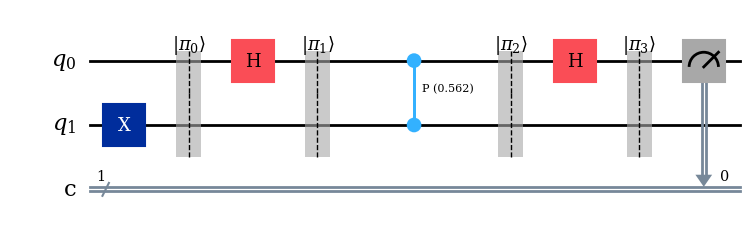

In [33]:
qc = re_circuit(angle)
qc.draw('mpl')

$$\text{Fig. }8:\text{ Hadamard test for Re}\langle\psi |U|\psi\rangle$$

In [34]:
def im_circuit(theta):
    circuit = QuantumCircuit(2,1) #Create circuit with 2 qubits and 1 classical bit
    circuit.x(1) #Apply pauli-x gate to q1 to put it to 1 state
    circuit.barrier(label='$|π_0\u27e9$')
    circuit.h(0) #Apply hadamard gate to q0 to put it into + state
    circuit.barrier(label='$|π_1$\u27e9')
    circuit.sdg(0) #Apply phase gate to make imaginary
    circuit.barrier(label='$|π_2$\u27e9')
    circuit.cp(theta,0,1) #Rotates q0 2*pi*theta radians if q1 is 1
    circuit.barrier(label='$|π_3$\u27e9')
    circuit.h(0) #Apply second hadamard gate to q0 to ensure the value phi affects our output
    circuit.barrier(label='$|π_4$\u27e9')
    circuit.measure(0,0) #Measure q0
    return circuit

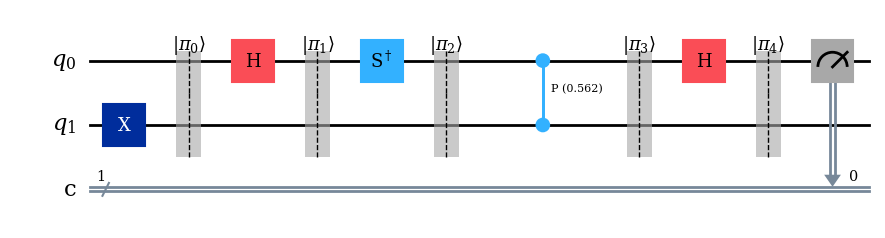

In [35]:
qc2 = im_circuit(angle)
qc2.draw('mpl')

$$\text{Fig. }9:\text{ Hadamard test for Re}\langle\psi |U|\psi\rangle$$

In [74]:
backend = BasicSimulator()

num_of_shots = 1000

re_result = backend.run(qc, shots=num_of_shots).result()   
re_counts = re_result.get_counts()                    

im_result = backend.run(qc2, shots=num_of_shots).result()   
im_counts = im_result.get_counts()                

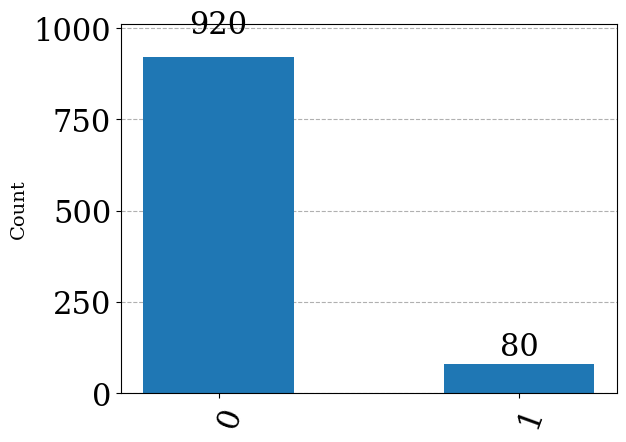

In [75]:
plot_histogram(re_counts)

$$\text{Fig. }10:\text{ Real Hadamard test counts}$$

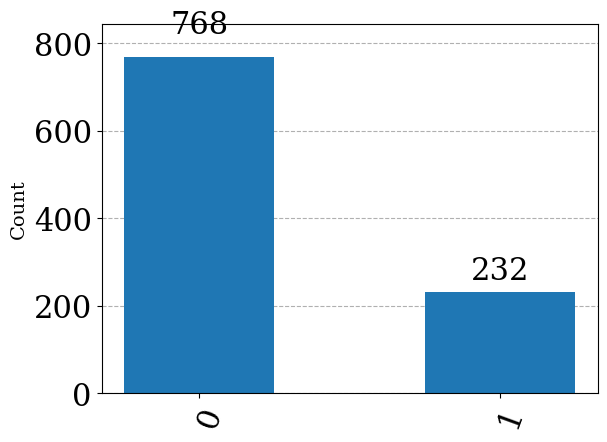

In [76]:
plot_histogram(im_counts)

In [1]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
bar0 = axes[0].bar([0,1], re_counts.values())
axes[0].bar_label(bar0, fmt = lambda x: int(x))
axes[0].set_xticks([0,1])
bar1 = axes[1].bar([0,1], im_counts.values())
axes[1].bar_label(bar1, fmt = lambda x: int(x))
axes[1].set_xticks([0,1])
axes[0].set_ylim(0,100)
axes[1].set_ylim(0,100)

axes[0].set_xlabel('Measured State')
axes[0].set_ylabel('Counts')
axes[0].set_title('Real Test')
axes[1].set_title('Imaginary Test')
fig.suptitle('Hadamard Test Counts', y = 1.025)
plt.show()

NameError: name 'plt' is not defined

$$\text{Fig. }11:\text{ Imaginary Hadamard test counts}$$

Using our computed equations for the measured probabilities $\mathbb{P}_{\text{Re}}(|0\rangle)$ and $\mathbb{P}_{\text{Re}}(|1\rangle)$, we can check that they match what we get from running the circuit.

$$\mathbb{P}_{\text{Re}}(|0\rangle) = \frac{1}{2}(1+\cos\theta) = \frac{1}{2}(1+\cos(0.5625)) \approx 0.9230$$

$$\mathbb{P}_{\text{Re}}(|1\rangle) = \frac{1}{2}(1-\cos\theta) = \frac{1}{2}(1-\cos(0.5625)) \approx 0.0770$$

Comparing this to the probabilites from the circuit, we can see they are very close to what we expect so we can say they do indeed match.

$$\mathbb{P}_{\text{Re}}(|0\rangle) = 0.9212$$

$$\mathbb{P}_{\text{Re}}(|1\rangle) = 0.0788$$

We can again do the same for the imaginary circuit where our computed probabilites are as follows

$$\mathbb{P}_{\text{Im}}(|0\rangle) = \frac{1}{2}(1-\sin\theta) = \frac{1}{2}(1-\sin(0.5625)) \approx 0.2333$$

$$\mathbb{P}_{\text{Im}}(|1\rangle) = \frac{1}{2}(1+\sin\theta) = \frac{1}{2}(1+\sin(0.5625)) \approx 0.7667$$

And comparing these to the probabilities from the circuit we again see that they are very close and matchup.

$$\mathbb{P}_{\text{Im}}(|0\rangle) = 0.23411$$

$$\mathbb{P}_{\text{Im}}(|1\rangle) = 0.76589$$


In [78]:
print('For Real Part:\nCalculated probability of measuring 0:\t',0.5*(1 + np.cos(angle)))
print('Calculated probability of measuring 1:\t', 0.5*(1 - np.cos(angle)))

print('Probability of measuring 0:\t\t', re_counts['0']/num_of_shots)
print('Probability of measuring 1:\t\t', re_counts['1']/num_of_shots)

print('\nFor Imaginary Part:\nCalculated probability of measuring 0:\t',0.5*(1 - np.sin(angle)))
print('Calculated probability of measuring 1:\t', 0.5*(1 + np.sin(angle)))

print('Probability of measuring 0:\t\t', im_counts['0']/num_of_shots)
print('Probability of measuring 1:\t\t', im_counts['1']/num_of_shots)

For Real Part:
Calculated probability of measuring 0:	 0.922962249615534
Calculated probability of measuring 1:	 0.07703775038446603
Probability of measuring 0:		 0.92
Probability of measuring 1:		 0.08

For Imaginary Part:
Calculated probability of measuring 0:	 0.23334866323198994
Calculated probability of measuring 1:	 0.7666513367680101
Probability of measuring 0:		 0.768
Probability of measuring 1:		 0.232


We can also clearly see that these probabilities both sum to $1$ which is what we expect. If we cycle through values of $\theta$ from $0\text{ rad}$ to $2\pi\text{ rad}$ and plot the probabilities of measuring $|1\rangle$ or $|0\rangle$, we can see that they always sum to 1.

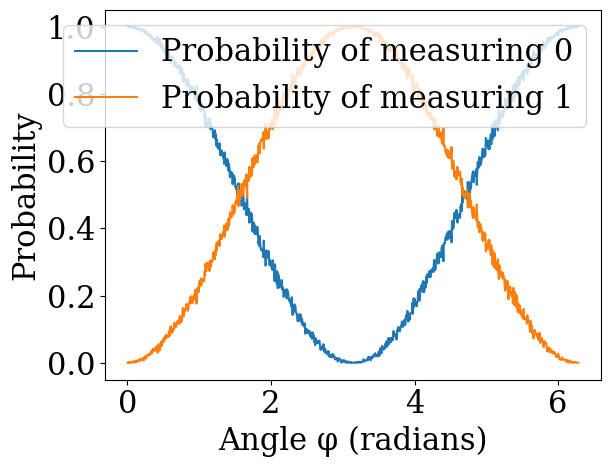

In [79]:
backend = BasicSimulator()

angles = np.linspace(0, 2*pi, 1000)
prob0 = []
prob1 = []
expected_phi = angles
for ang in angles:
    circ = re_circuit(ang)
    num_of_shots = int(num_of_shots)
    counts = backend.run(circ, shots=num_of_shots).result().get_counts()
    prob0val = counts.get('0')
    prob1val = counts.get('1')
    if prob0val is not None and prob1val is not None:        
        prob0.append(counts['0']/num_of_shots)
        prob1.append(counts['1']/num_of_shots)
    elif prob0val is None:
        prob0.append(0)
        prob1.append(counts['1']/num_of_shots)
    elif prob1val is None:
        prob0.append(counts['0']/num_of_shots)
        prob1.append(0)
plt.plot(angles, prob0, label = 'Probability of measuring 0')
plt.plot(angles, prob1, label = 'Probability of measuring 1')
plt.xlabel('Angle \u03C6 (radians)')
plt.ylabel('Probability')
plt.legend(loc = 'upper right')
plt.show()

$$\text{Fig. }12:\text{ Probabilities of measuring }0\text{ and }1\text{ for the Hadamard test}$$

Now that we have obtained the probabilities for each circuit, we can compute $\text{Re}\langle\psi|U|\psi\rangle$ using any equation in $\eqref{re_prob}$ and $\text{Im}\langle\psi|U|\psi\rangle$ using any equation in $\eqref{im_prob}$. 

In [80]:
print("Results of the Trial: ")
print("  Real Circuit:  \t",re_counts)
print("  Imginary Circuit:\t",im_counts)

re_p0 = re_counts['0']/num_of_shots
re_p1 = re_counts['1']/num_of_shots
im_p0 = im_counts['0']/num_of_shots
im_p1 = im_counts['1']/num_of_shots

re = re_p0 - re_p1
#re = 2*(re_p0) - 1
#re = 1 - 2*(re_p1)

im = im_p0 - im_p1
#im = 1 - 2*(im_p0)
#im = 2*(im_p1) - 1

print('\nRe\u27e8\u03c8|U|\u03c8\u27e9 = ',re)
print('Im\u27e8\u03c8|U|\u03c8\u27e9 = ',im)

Results of the Trial: 
  Real Circuit:  	 {'0': 920, '1': 80}
  Imginary Circuit:	 {'0': 768, '1': 232}

Re⟨ψ|U|ψ⟩ =  0.8400000000000001
Im⟨ψ|U|ψ⟩ =  0.536


Finally, we can use either or both of these values to estimate the phase angle $\theta$ using any equation in $\eqref{angle}$.

Because the trigonometic functions are cyclic, the inverse trigonometic functions, have multiple possible angles they could return, so the standard for this types of functions is to return the first value. To get around this we can use the outputs of both arccos and arcsin to determine which quandrant the angle is in.

The range of arccos is greater $0$ to $\pi$, and the range of arcsin is $-\pi/2$ to $\pi/2$. We can use arccos to determine if the angle is in the positive x or negitive x part of the graph, and we can use arcsin to determine if it is in the positive y or negative y part of the graph.

Using the angle returned from arccos, if we get a negative value from arcsin then we have to determine the angle in the negative y part of the graph. To do this we can set $\theta$ to $2\pi-\theta$. 

Using the angle returned from arcsin, if we get a value greater than $\pi/2$ then we have to determine the angle in the negative x part of the graph. To do this we can set $\theta$ to $\pi-\theta$. 

For a visual explaination you can look at <a href="https://www.desmos.com/calculator/woyndzal2n">this graph</a>.

In [85]:
#equation_number = 1 # use cosine to determine angle and sine to determine sign
#equation_number = 2 # use sine to determine angle and cosine to determine sign
equation_number = 3 # use tan to determine angle

In [86]:
ans = 0
if equation_number == 1:
    cos_angle = np.arccos(re)
    if  np.arcsin(im)<0:
        ans = 2*pi - cos_angle
    else:
        ans = cos_angle
elif equation_number == 2:
    sin_angle = np.arcsin(im)
    if  np.arccos(re)>pi/2:
        ans = pi - sin_angle
    else:
        ans = sin_angle
else:
    ans = np.arctan2(im,re)

# make sure the angle is positive for comparision
if ans < 0: ans = ans + 2*pi
print("\nEstimated phase angle:\t", ans)
print("Exact phase angle:\t", angle)


Estimated phase angle:	 0.5679607439945007
Exact phase angle:	 0.5625


We have now successfuly estimated the angle $\theta = 0.5625$ to be $\theta \approx 0.5564$. The accuracy of this estimation is directly dependent on the number of shots or how many times the circuit is run. The more shots we use, the more accurate our probabilites will be and thus our expectaions values and phase angle will be estimated to higher precision. By running this circuit for an increasing number of shots, we can see the convergence of the error with respect to the number of shots.

In [81]:
# Construct a graph of error verses number of shots
backend = BasicSimulator()

trials = np.logspace(3, 5, 20)
Ns = []
error_diff = []
for num_of_shots in trials:
    # for some reason python doesn't believe this number is an integer
    num_of_shots = int(num_of_shots)
    re_counts = backend.run(qc, shots=num_of_shots).result().get_counts() 
    im_counts = backend.run(qc2, shots=num_of_shots).result().get_counts() 

    re_p0 = re_p1 = im_p0 = im_p1 = 0
    
    if re_counts.get('0') is not None:
        re_p0 = re_counts['0']/num_of_shots
        
    if re_counts.get('1') is not None:
        re_p1 = re_counts['1']/num_of_shots
        
    if im_counts.get('0') is not None:
        im_p0 = im_counts['0']/num_of_shots
        
    if im_counts.get('1') is not None:
        im_p1 = im_counts['1']/num_of_shots

    re = re_p0 - re_p1
    im = im_p1 - im_p0
    error_diff.append((re_p0*(1 - re_p0)/num_of_shots)**(0.5))
    Ns.append( angle*num_of_shots**(-0.5) )

error_diff=np.array(error_diff)

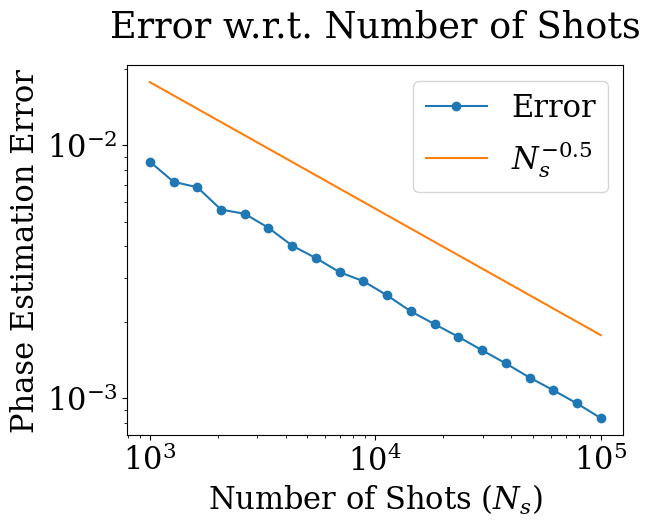

In [91]:
plt.loglog(trials, error_diff, label = 'Error',marker='o')
plt.loglog(trials, Ns, label = '$N_s^{-0.5}$')
plt.title("Error w.r.t. Number of Shots", pad = 20)
plt.xlabel("Number of Shots $(N_s)$")
plt.ylabel("Phase Estimation Error")
plt.legend(loc='upper right')
plt.show()

$$\text{Fig. }13:\text{ Error convergence with respect to number of shots}$$

To determine the error for using $\arccos$ to estimate the angle, we first need to find the variance of our qubit's output which is dependent on $\arccos$.

When we are measuring a qubit, we know the only possible outcomes are $0$ and $1$. From this, we can say that this measurement is a discrete binary distribution, meaning it has two possible outcomes. These outcomes are event $1$ and event $2$, where their probabilities sum to $1$. You might recognize that this is exactly the definition of a Bernoulli distribution. Say we have some random variable $X$ that represents the measurement of a qubit where the probability of measuring $0$ is $p(0)=p$. $X$ can then be defined with the following probability density function (PDF)

$$ \mathbb{P}(X)=   \left\{
\begin{array}{ll}
      p(0)=p & \text{for } X=0 \\
      p(1)=1-p & \text{for } X=1 \\
\end{array} 
\right.  $$

In the case of the real Hadamard test, recall that $\mathbb{P}_{\text{Re}}(|0\rangle) = \frac{1}{2}(1+\text{Re}\langle\psi|U|\psi\rangle)$. To verify that this test follows a Bernoulli distribution, the probabilities for this test must follow $\mathbb{P}_{\text{Re}}(|1\rangle) = 1-\mathbb{P}_{\text{Re}}(|0\rangle)$. Attempting to verify this we see that $$\mathbb{P}_{\text{Re}}(|1\rangle) = 1 - \frac{1}{2}(1+\text{Re}\langle\psi|U|\psi\rangle) = \frac{1}{2}(1-\text{Re}\langle\psi|U|\psi\rangle)$$ which is the actual probability, therefore confirming that this is in fact a Bernoulli distribution. 

To compute the variance in our phase angle $\theta$, the probability of these events is estimated with respect to some number of shots $N_s$. Let's look at event $1$ which we take to be measuring $0$ from the qubit. First, we let $X_j \sim X$ to be independent and identically distributed (i.i.d) for $j=1,\dots,N_s$. This simply means that $X_j$ for every $j$ is mutually independent and has the same probability distribution. We can then define the probability of measuring this event with respect to $N_s$ to be estimated by 

$$\mathbb{P}(0) = \frac{1}{N_s}\sum_{j=1}^{N_s}\mathbb{1}_{0}(X_j)$$

where $\mathbb{1}$ is called the indicator function which tells us if our outcome is of event type $1$ or $2$:

$$ \mathbb{1}_A(x)=   \left\{
\begin{array}{ll}
      1 & \text{if } x \in A\\
      0 & \text{if } x \notin A \\
\end{array} 
\right.  $$

This type of estimator is called a Monte Carlo estimator. Say we have some random variable $X$ with probability density function $\rho_X(x)$ and we want to estimate the probability of obtaining $0$ with $N_s$ shots. We then find the expectation value of $X$ to be

$$\mathbb{E}(\mathbb{P}(0)) = \frac{1}{N_s}\sum_{j=1}^{N_s}\mathbb{E}(\mathbb{1}_{0}(X_j)) = \frac{1}{N_s}\sum_{j=1}^{N_s}\int_{-\infty}^{\infty}\mathbb{1}_{0}(x)\rho_X (x)dx = \frac{1}{N_s}\sum_{j=1}^{N_s}\rho_X (0) = \frac{1}{N_s}\sum_{j=1}^{N_s}p(0)$$

meaning the average value we obtain from the estimator $\mathbb{P}(0)$ is the probability of event $1$ $p(0)$. What we are actually looking for (and what is portrayed in the plot), is a measure of "how accurate" our estimator is when using some number of shots $N_s$. Hence, the "standard deviation" $\sigma$ is the value we are looking for. This is a measure of how dispersed a set of data is in relation to its mean. This value $\sigma$ is defined as the square root of the variance of the data. The variance of a function can be computed from its expectation value by the formula

$$S^2 = \mathbb{E}(\mathbb{P}(0)^2) - \mathbb{E}(\mathbb{P}(0))^2$$

Performing this calculation on our estimator function we compute the variance to be

$$S^2 = \frac{1}{N_s^2}\sum_{j=1}^{N_s}S^2(\mathbb{1}_{0}(X_j)) = \frac{1}{N_s^2}\sum_{j=1}^{N_s}\mathbb{E}(\mathbb{1}_{0}(X_j)^2) - \mathbb{E}(\mathbb{1}_{0}(X_j))^2 = \frac{1}{N_s^2}\sum_{j=1}^{N_s}\mathbb{E}(\mathbb{1}_{0}(X_j)) - \mathbb{E}(\mathbb{1}_{0}(X_j))^2 = \frac{1}{N_s^2}\sum_{j=1}^{N_s}p(0)-p(0)^2 = \frac{p(0)(1-p(0))}{N_s}$$

which gives us a standard deviation of 

$$\sigma = \sqrt{S^2} = \sqrt{\frac{p(0)(1-p(0))}{N_s}}$$

Say we choose some value $\epsilon$ to be our pre-defined accuray goal. In order for our estimation to be as good or better than we want, $\sigma \leq \epsilon$ must be true. Therefore, the number of shots $N_s$ we need to obtain this goal is given by

$$\epsilon \geq \sigma = \sqrt{\frac{p(0)(1-p(0))}{N_s}} \Rightarrow \epsilon ^2 \geq \frac{p(0)(1-p(0))}{N_s} \Rightarrow N_s \geq \frac{p(0)(1-p(0))}{\epsilon ^2}$$